<a href="https://colab.research.google.com/github/Vignesh-397/Image_Dehazing/blob/main/Image_Dehazing_By_Resizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing libraries**



In [ ]:
import os
import numpy as np
import shutil
import glob
import cv2
import matplotlib.pyplot as plt
import glob

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import ModelCheckpoint

## **Specifying paths for dataset**

In [ ]:
train_hazy_path = glob.glob('/content/drive/MyDrive/dataset/train/hazy/*')

gt_path = '/content/drive/MyDrive/dataset/train/clear/'

savepath ="/content/outdoorunet-{epoch:02d}-{loss:.4f}.hdf5"

batch_size = 6

## **Image loading to train dataset**

In [ ]:
# get images in batch
def get_images(path):
    imgs = []
    for i in path:
        img = cv2.imread(i)/255.
        I = img

        l = cv2.resize(I, (256, 256))

        imgs.append(l)

    return imgs

def get_gt_images(path):
    imgs = []
    for hazy_image_path in path:
        filename = os.path.basename(hazy_image_path)

        gt_image_path = os.path.join(gt_path, filename)

        img = cv2.imread(gt_image_path)
        I = img / 255.0
        l = cv2.resize(I, (256, 256))

        imgs.append(l)

    return imgs

## **Loading images as batches for training**

In [ ]:

def train_generator(train_path, batch_size):
    L = len(train_path)
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            # X_load as input images
            X_load = get_images(train_path[batch_start:limit])
            # Y_load as ground truth images
            Y_load = get_gt_images(train_path[batch_start:limit])

            # Stack the images load as batch
            X = np.stack(X_load, axis=0)
            Y = np.stack(Y_load, axis=0)

            batch_start += batch_size
            batch_end += batch_size

            yield (X, Y)


## **Generating validation data**

In [ ]:
def val_generator(val_path, batch_size):
    L = len(val_path)
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X_load = get_images(val_path[batch_start:limit])
            Y_load = get_gt_images(val_path[batch_start:limit])
            X = np.stack(X_load, axis=0)
            Y = np.stack(Y_load, axis=0)

            batch_start += batch_size
            batch_end += batch_size

            yield (X, Y)

## **Create the VGG model**

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
content_layer = 'block2_conv2'
loss_model = Model(vgg.input, vgg.get_layer(content_layer).output)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Perceptual loss using VGG19
def lossVGG(y_true, y_pred, loss_model):
    vggX = loss_model(y_pred)
    vggY = loss_model(y_true)
    return K.mean(K.square(vggX - vggY))

# Total loss
def my_loss(y_true, y_pred):
    mse = MSE(y_true, y_pred)
    return lossVGG(y_true, y_pred, loss_model) + mse

##Something idk

In [ ]:
# SE block
def squeeze_excite_block(tensor):
    init = tensor
    channel_axis = 3
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    # Set ratio to reduce the complexity of output channel as 8
    r = 8
    se = Dense(filters // r, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    x = multiply([init, se])
    return x

## **Model implementation**

In [ ]:
def dseu():
    inputs = Input((None, None, 3))

    # Encoder part
    conv1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    dilate1 = Conv2D(256, (3, 3), padding='same', dilation_rate=1, kernel_initializer='he_normal')(pool4)
    dilate1 = BatchNormalization()(dilate1)
    dilate1 = Activation('relu')(dilate1)
    dilate2 = Conv2D(256, (3, 3), padding='same', dilation_rate=2, kernel_initializer='he_normal')(pool4)
    dilate2 = BatchNormalization()(dilate2)
    dilate2 = Activation('relu')(dilate2)
    dilate3 = Conv2D(256, (3, 3), padding='same', dilation_rate=4, kernel_initializer='he_normal')(pool4)
    dilate3 = BatchNormalization()(dilate3)
    dilate3 = Activation('relu')(dilate3)
    dilate4 = Conv2D(256, (3, 3), padding='same', dilation_rate=8, kernel_initializer='he_normal')(pool4)
    dilate4 = BatchNormalization()(dilate4)
    dilate4 = Activation('relu')(dilate4)

    convm = concatenate([dilate1, dilate2, dilate3, dilate4], axis=3)

    # Decoder part
    up6 = UpSampling2D(size=(2, 2))(convm)
    up6 = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal')(up6)
    up6 = BatchNormalization()(up6)
    up6 = Activation('relu')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal')(up7)
    up7 = BatchNormalization()(up7)
    up7 = Activation('relu')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), padding='same', kernel_initializer='he_normal')(up8)
    up8 = BatchNormalization()(up8)
    up8 = Activation('relu')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), padding='same', kernel_initializer='he_normal')(up9)
    up9 = BatchNormalization()(up9)
    up9 = Activation('relu')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Activation('sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

## **Compiling the model**

In [ ]:
model = dseu()
model.compile(optimizer=Adam(lr=1e-4), loss=my_loss, metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 64)       256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 64)       0         ['batch_normalization[0]

## **Define checkpoint**

In [ ]:
model_checkpoint = ModelCheckpoint(savepath, monitor='loss', verbose=1, save_best_only=True)

## **Training the Model**

In [ ]:
history = model.fit(train_generator(train_hazy_path, batch_size),
                    steps_per_epoch=len(train_hazy_path)//batch_size,
                    epochs=20, verbose=1, callbacks=[model_checkpoint])

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.9745 - accuracy: 0.5507
Epoch 1: loss improved from inf to 0.97451, saving model to /content/outdoorunet-01-0.9745.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 993s 6s/step - loss: 0.9745 - accuracy: 0.5507
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.6178
Epoch 2: loss improved from 0.97451 to 0.55998, saving model to /content/outdoorunet-02-0.5600.hdf5
150/150 [==============================] - 79s 528ms/step - loss: 0.5600 - accuracy: 0.6178
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.6396
Epoch 3: loss improved from 0.55998 to 0.48547, saving model to /content/outdoorunet-03-0.4855.hdf5
150/150 [==============================] - 81s 543ms/step - loss: 0.4855 - accuracy: 0.6396
Epoch 4/20
150/150 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.6546
Epoch 4: loss improved from 0.48547 to 0.44317, saving model to /content/outdoorunet-04-0.4432.hdf5
150/150 [==============================] - 1212s 8s/step - loss: 0.4432 - accuracy: 0.6546
Epoch 5/20
150/150 [===========================

## **Saving the model**

In [ ]:
model.save('/content/dehazing_model.h5')
model.save('/content/drive/Mydrive/Samsung Prism/dehazing_model.h5')

#**Testing the model**

## **Load the Model**

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/content/drive/Mydrive/Samsung Prism/dehazing_model.h5', custom_objects={'my_loss': my_loss})

## **Functions to Load and Visualize the results**

In [ ]:
# Function to load test images
def load_test_images(test_path):
    imgs = []
    for i in test_path:
        img = cv2.imread(i) / 255.0
        img_resized = cv2.resize(img, (256, 256))
        imgs.append(img_resized)
    return np.array(imgs)

# Function to visualize the results
def visualize_results(original, predicted):
    # Convert images from float to uint8
    original_uint8 = (original * 255).astype(np.uint8)
    predicted_uint8 = (predicted * 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_uint8, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Plot predicted image
    plt.subplot(1, 2, 2)
    plt.title("Dehazed Image")
    plt.imshow(cv2.cvtColor(predicted_uint8, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


## **Loading the test images**

In [ ]:
# Load test images
test_hazy_path = glob.glob('/content/drive/MyDrive/dataset/test/hazy/*')  # Change to your test images path
test_images = load_test_images(test_hazy_path)

2/2 [==============================] - 1s 679ms/step


## **Performing predictions**

In [ ]:
predicted_images = model.predict(test_images)

## **Visualize the results**

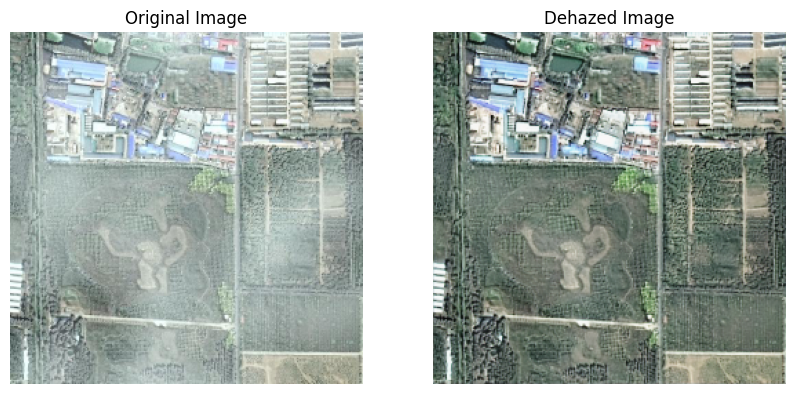

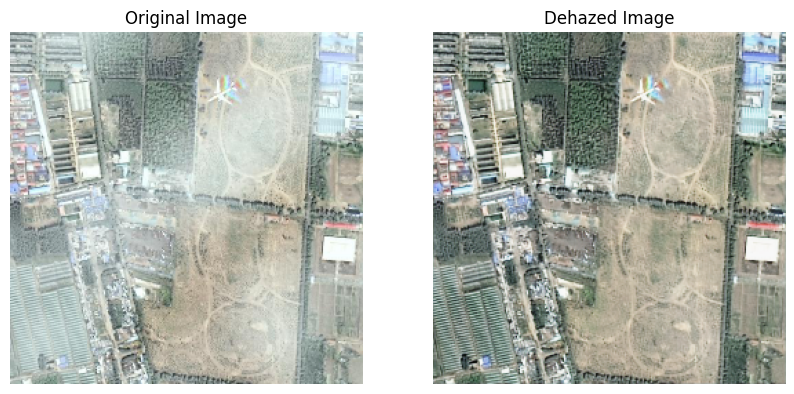

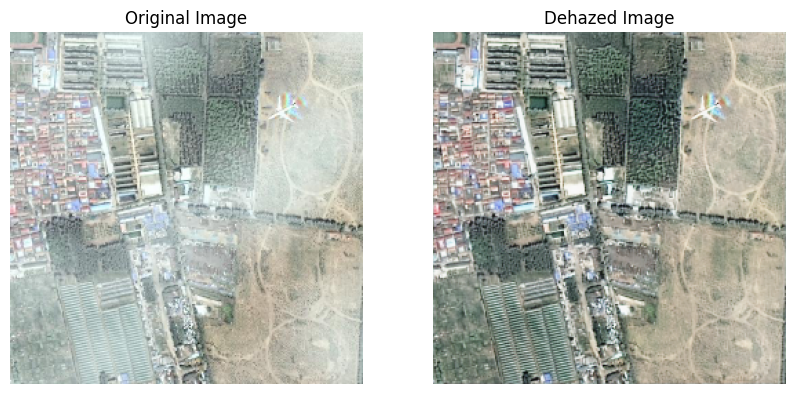

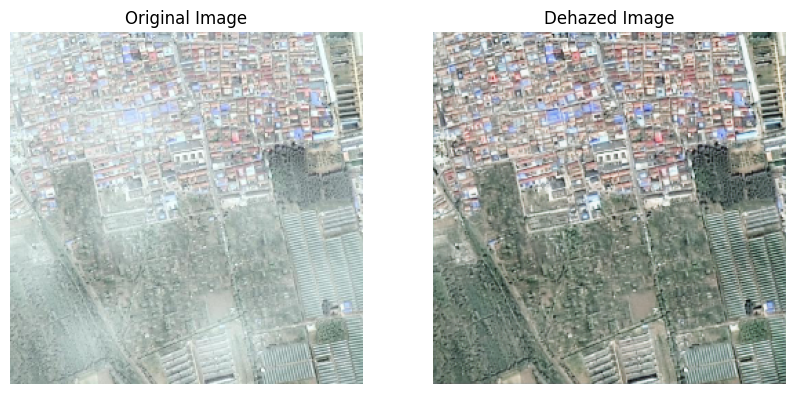

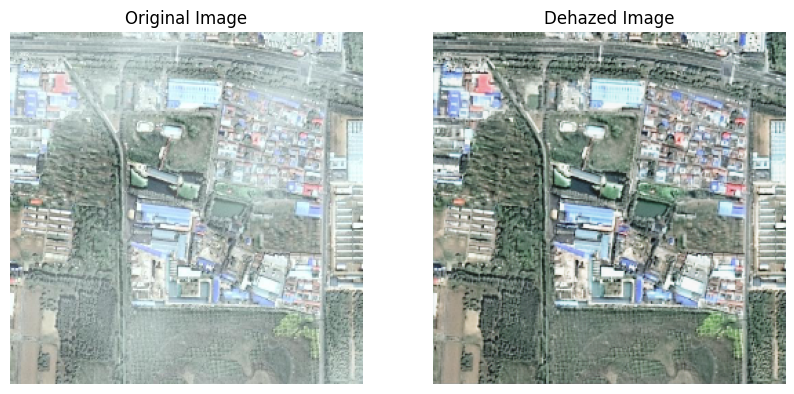

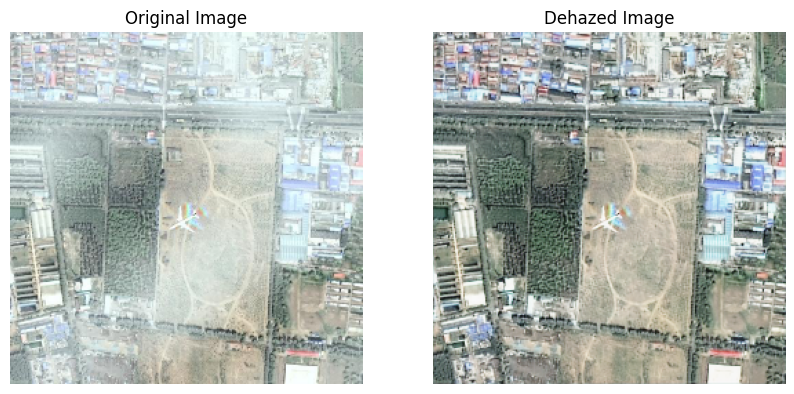

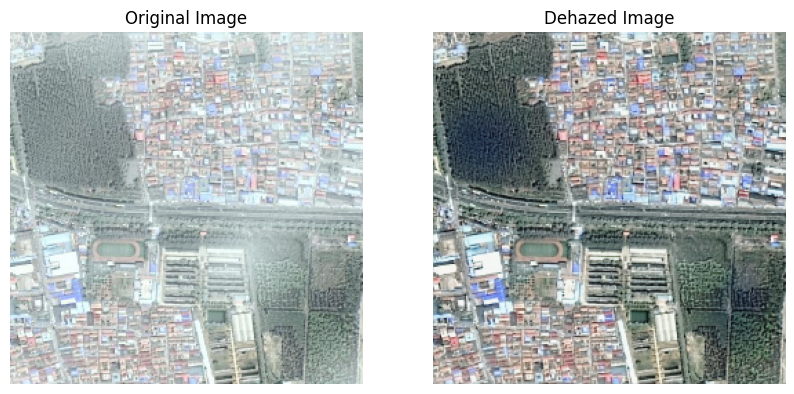

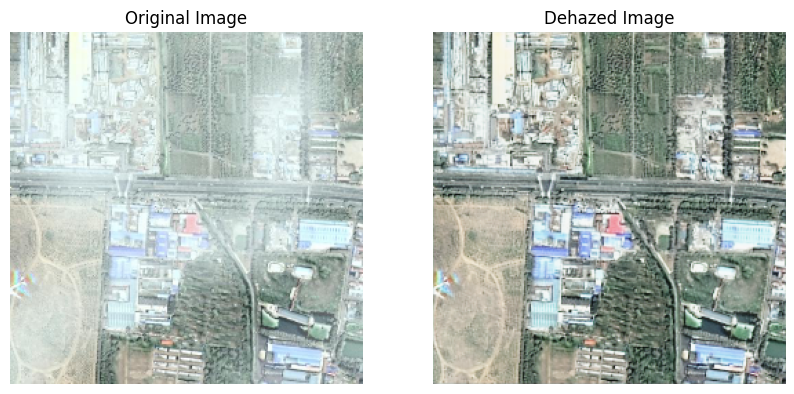

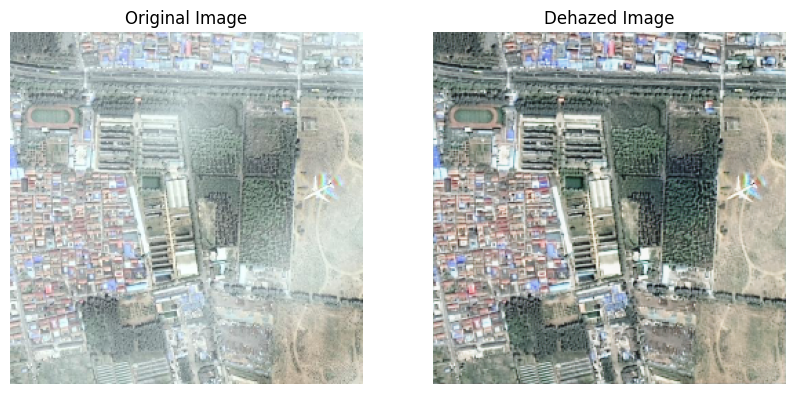

In [ ]:
for original, predicted in zip(test_images, predicted_images):
    visualize_results(original, predicted)